In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient

In [2]:
# ⚙️ Ajusta estos valores a tu entorno
MONGO_URI = "mongodb://localhost:27017"   # o tu cadena completa (usuario/clave/host/puerto)
DB_NAME = "educacion_chile"               # nombre de la base que usaste al cargar los datos
COLLECTION = "estudiantes_tecnicos"       # nombre de la colección con el dataset

client = MongoClient(MONGO_URI)
db = client[DB_NAME]
col = db[COLLECTION]

# Prueba rápida de conexión y conteo
num_docs = col.count_documents({})
print(f"Conectado ✅  | Documentos en la colección: {num_docs}")

Conectado ✅  | Documentos en la colección: 84


In [5]:
# Si quieres limitar campos, define un 'projection' (ejemplo abajo). Si no, usa None.
projection = None
# projection = {
#     "_id": 0,
#     "asistencia": 1,
#     "promedio_notas": 1,
#     "genero": 1,
#     "tipo_establecimiento": 1,
#     "condicion_socioeconomica": 1,
#     "riesgo_desercion": 1,      # objetivo de REGRESIÓN (continua)
#     "abandono_reportado": 1     # objetivo de CLASIFICACIÓN (0/1 o True/False)
# }

cursor = col.find({}, projection)
df = pd.DataFrame(list(cursor))
df = df.drop(columns=['_id'])

print("Filas x Columnas:", df.shape)
df.head()

Filas x Columnas: (84, 11)


,nombre,genero,edad,region,comuna,asistencia,promedio_notas,tipo_establecimiento,condicion_socioeconomica,riesgo_desercion,abandono_reportado
0,Camila Torres,F,17,Región Metropolitana,Puente Alto,62,4.8,municipal,baja,0.82,True
1,Ignacio Paredes,M,18,Región Metropolitana,Maipú,68,5.1,municipal,baja,0.73,False
2,Valentina Rojas,F,17,Región Metropolitana,Las Condes,91,6.4,particular,alta,0.12,False
3,Matías Herrera,M,16,Región Metropolitana,San Bernardo,70,5.0,municipal,media,0.58,False
4,Daniela González,F,18,Región Metropolitana,Vitacura,95,6.6,particular,alta,0.09,False


In [6]:
# Tipos de datos
print(df.dtypes, "\n")

# Conteo de nulos por columna
print("Nulos por columna:\n", df.isna().sum(), "\n")

# Vistazo estadístico rápido de columnas numéricas
display(df.describe())

# Guardar una copia limpia en memoria para siguientes pasos
data = df.copy()
print("Dataset listo para modelado ✅")

nombre                       object
genero                       object
edad                          int64
region                       object
comuna                       object
asistencia                    int64
promedio_notas              float64
tipo_establecimiento         object
condicion_socioeconomica     object
riesgo_desercion            float64
abandono_reportado             bool
dtype: object 

Nulos por columna:
 nombre                      0
genero                      0
edad                        0
region                      0
comuna                      0
asistencia                  0
promedio_notas              0
tipo_establecimiento        0
condicion_socioeconomica    0
riesgo_desercion            0
abandono_reportado          0
dtype: int64 



,edad,asistencia,promedio_notas,riesgo_desercion
count,84.000000,84.000000,84.000000,84.000000
mean,17.023810,75.928571,5.476190,0.461905
std,0.775781,10.717383,0.628178,0.255642
min,16.000000,54.000000,4.300000,0.070000
25%,16.000000,68.000000,4.900000,0.247500
50%,17.000000,76.500000,5.500000,0.425000
75%,18.000000,85.000000,6.000000,0.702500
max,18.000000,95.000000,6.700000,0.950000


Dataset listo para modelado ✅


In [7]:
from sklearn.model_selection import train_test_split

# Variables predictoras (features)
features = ["asistencia", "promedio_notas",
            "genero", "tipo_establecimiento", "condicion_socioeconomica"]

# Objetivos
target_reg = "riesgo_desercion"      # regresión
target_clf = "abandono_reportado"    # clasificación

# --- Copias separadas para cada tarea ---
X_reg = data[features].copy()
y_reg = data[target_reg].copy()

X_clf = data[features].copy()
y_clf = data[target_clf].copy()

In [8]:
# ⚠️ Solo convertimos si es necesario.
# Ejemplo: para clasificación, asegurar que y_clf sea int (0/1)
if y_clf.dtype == bool:
    y_clf = y_clf.astype(int)

print("Tipo de y_reg:", y_reg.dtype)
print("Tipo de y_clf:", y_clf.dtype)

Tipo de y_reg: float64
Tipo de y_clf: int32


In [9]:
# División 80/20 con semilla reproducible
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

print("Regresión → Train:", X_train_reg.shape, " | Test:", X_test_reg.shape)
print("Clasificación → Train:", X_train_clf.shape, " | Test:", X_test_clf.shape)

Regresión → Train: (67, 5)  | Test: (17, 5)
Clasificación → Train: (67, 5)  | Test: (17, 5)


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Reusa la lista 'features' definida en el paso 2
numeric_features = ["asistencia", "promedio_notas"]
categorical_features = ["genero", "tipo_establecimiento", "condicion_socioeconomica"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pipeline de REGRESIÓN
reg_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

# Entrenar
reg_pipeline.fit(X_train_reg, y_train_reg)

# Predecir y medir
y_pred_reg = reg_pipeline.predict(X_test_reg)

mae  = mean_absolute_error(y_test_reg, y_pred_reg)
mse  = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2   = r2_score(y_test_reg, y_pred_reg)

metrics_reg = pd.DataFrame({
    "Métrica": ["MAE", "MSE", "RMSE", "R²"],
    "Valor":   [mae, mse, rmse, r2]
})
metrics_reg

,Métrica,Valor
0,MAE,0.022290
1,MSE,0.000831
2,RMSE,0.028835
3,R²,0.990266


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# Pipeline de CLASIFICACIÓN (KNN)
clf_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

# Entrenar
clf_pipeline.fit(X_train_clf, y_train_clf)

# Predicciones
y_pred_clf = clf_pipeline.predict(X_test_clf)
y_proba_clf = clf_pipeline.predict_proba(X_test_clf)[:, 1]  # para AUC/ROC

# Métricas básicas
accuracy   = accuracy_score(y_test_clf, y_pred_clf)
precision  = precision_score(y_test_clf, y_pred_clf, zero_division=0)
recall     = recall_score(y_test_clf, y_pred_clf, zero_division=0)

# Especificidad desde la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test_clf, y_pred_clf).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# AUC
auc = roc_auc_score(y_test_clf, y_proba_clf)

metrics_clf = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall (Sensibilidad)", "Especificidad", "AUC"],
    "Valor":   [accuracy, precision, recall, specificity, auc]
})
metrics_clf

,Métrica,Valor
0,Accuracy,0.941176
1,Precision,1.000000
2,Recall (Sensibilidad),0.800000
3,Especificidad,1.000000
4,AUC,0.991667


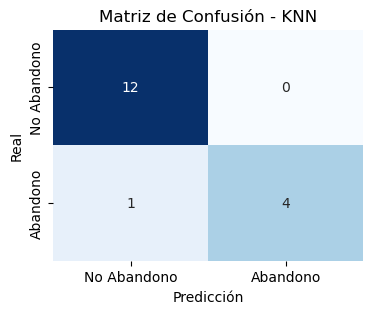

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar matriz
cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Abandono", "Abandono"],
            yticklabels=["No Abandono", "Abandono"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - KNN")
plt.show()

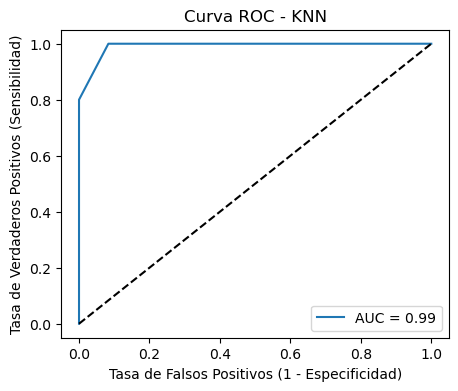

In [14]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test_clf, y_proba_clf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--")  # línea aleatoria
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC - KNN")
plt.legend(loc="lower right")
plt.show()